In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bpic17iteration/DataIteration.csv


In [2]:
db  = pd.read_csv("/kaggle/input/bpic17iteration/DataIteration.csv")
data = db.copy()

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier as snapForest
from sklearn.tree import DecisionTreeClassifier as decisionTree
from sklearn.neural_network import MLPClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression as logistR
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay,ConfusionMatrixDisplay,classification_report
import seaborn as sns

In [4]:
target = np.where((db['lifecycle:transition'] == 'ate_abort') | (db['iteration'] >= 3),1,0)

In [5]:
# normalize data (this is important for model convergence)
def encode(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = LabelEncoder().fit_transform(db[k])
    return db.astype('float')

In [6]:
data = encode(data)

In [7]:
feat =  ['org:resource','concept:name',
         'EventOrigin','Selected',
         'CreditScore','NumberOfTerms',
         'OfferedAmount','case:RequestedAmount',
         'case:LoanGoal', 'lifecycle:transition',
         'iteration']
new = db[feat]

In [8]:
def encodeonehot(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = OneHotEncode().fit_transform(db[k])
    return db.astype('float')

<Axes: >

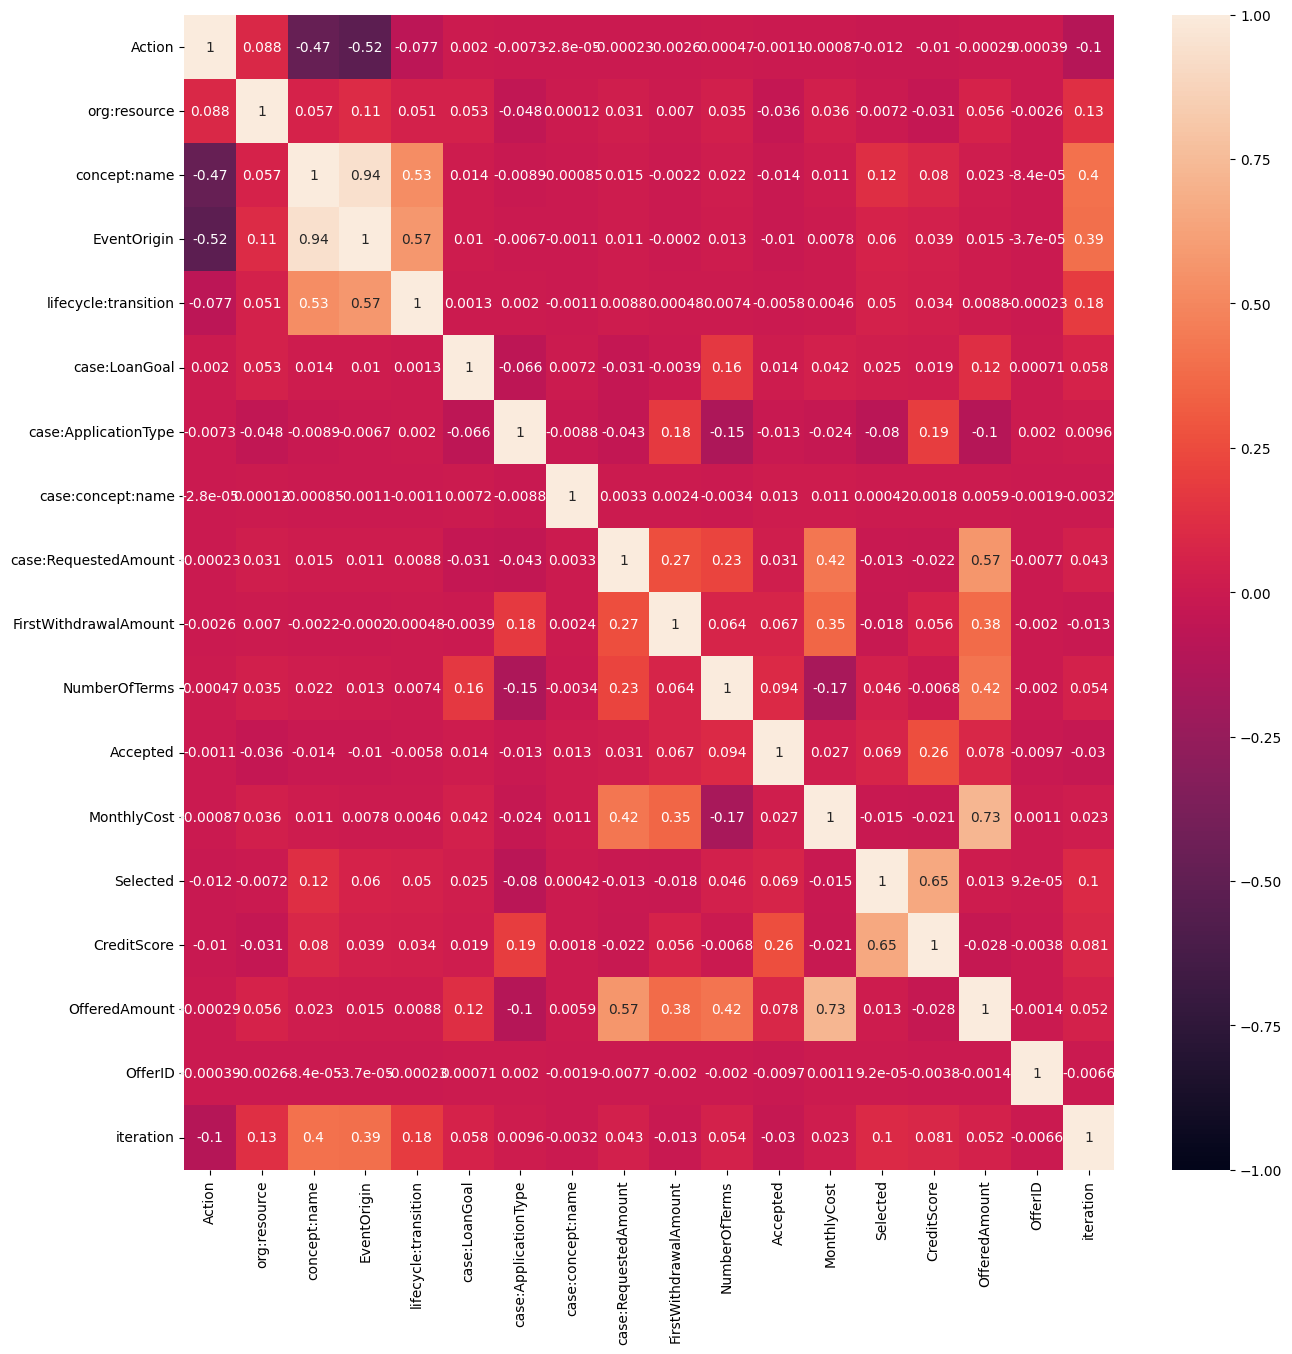

In [9]:
corr = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True, vmin=-1, vmax=1)

In [10]:
oneHot = OneHotEncoder(handle_unknown='ignore')

In [11]:
col = new.columns.where(new.dtypes == object)
onehotcol = []
for c in col:
    if type(c) == str:
        onehotcol.append(c)

In [12]:
preprocessing = ColumnTransformer([
    ('OneHot_cat', oneHot, onehotcol)
])

In [13]:
rf = Pipeline([
    ('prepocess', preprocessing),
    ('classifier', snapForest(n_estimators=400))
])

In [14]:
dt = Pipeline([
        ('prepocess', preprocessing),
        ('classifier', decisionTree(max_depth=4))
])

In [15]:
lr = Pipeline([
        ('prepocess', preprocessing),
        ('classifier', logistR(C=0.1,random_state=0, max_iter = 100))
])

In [16]:
mlp = Pipeline([
        ('prepocess', preprocessing),
        ('classifier', MLPClassifier(activation = 'relu', hidden_layer_sizes= (400,),random_state=1, max_iter=100))
])

In [17]:
new.head()

,org:resource,concept:name,EventOrigin,Selected,CreditScore,NumberOfTerms,OfferedAmount,case:RequestedAmount,case:LoanGoal,lifecycle:transition,iteration
0,User_1,A_Create Application,Application,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,complete,1
1,User_1,A_Submitted,Application,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,complete,1
2,User_1,W_Handle leads,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,schedule,1
3,User_1,W_Handle leads,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,withdraw,2
4,User_1,W_Complete application,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,schedule,1


In [18]:
xtrain,xtest,ytrain,ytest = train_test_split(new,target, train_size=0.8, shuffle=False)

In [19]:
xtrain.head()

,org:resource,concept:name,EventOrigin,Selected,CreditScore,NumberOfTerms,OfferedAmount,case:RequestedAmount,case:LoanGoal,lifecycle:transition,iteration
0,User_1,A_Create Application,Application,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,complete,1
1,User_1,A_Submitted,Application,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,complete,1
2,User_1,W_Handle leads,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,schedule,1
3,User_1,W_Handle leads,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,withdraw,2
4,User_1,W_Complete application,Workflow,True,979.0,44.0,20000.0,20000.0,Existing loan takeover,schedule,1


In [20]:
rf.fit(xtrain, ytrain)

Pipeline(steps=[('prepocess',
                 ColumnTransformer(transformers=[('OneHot_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['org:resource',
                                                   'concept:name',
                                                   'EventOrigin',
                                                   'case:LoanGoal',
                                                   'lifecycle:transition'])])),
                ('classifier', RandomForestClassifier(n_estimators=400))])

In [21]:
dt.fit(xtrain, ytrain)

Pipeline(steps=[('prepocess',
                 ColumnTransformer(transformers=[('OneHot_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['org:resource',
                                                   'concept:name',
                                                   'EventOrigin',
                                                   'case:LoanGoal',
                                                   'lifecycle:transition'])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [22]:
lr.fit(xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('prepocess',
                 ColumnTransformer(transformers=[('OneHot_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['org:resource',
                                                   'concept:name',
                                                   'EventOrigin',
                                                   'case:LoanGoal',
                                                   'lifecycle:transition'])])),
                ('classifier', LogisticRegression(C=0.1, random_state=0))])

In [23]:
mlp.fit(xtrain,ytrain)

Pipeline(steps=[('prepocess',
                 ColumnTransformer(transformers=[('OneHot_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['org:resource',
                                                   'concept:name',
                                                   'EventOrigin',
                                                   'case:LoanGoal',
                                                   'lifecycle:transition'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(400,), max_iter=100,
                               random_state=1))])

In [24]:
lr_pred = lr.predict(xtest)
rf_pred = rf.predict(xtest)
dt_pred = dt.predict(xtest)
mlp_pred = mlp.predict(xtest)

In [25]:
from pickle import dump
with open("lrmodel.pkl", "wb") as f:
    dump(lr, f, protocol=5)
with open("rfmodel.pkl", "wb") as f:
    dump(rf, f, protocol=5)
with open("dtmodel.pkl", "wb") as f:
    dump(dt, f, protocol=5)
with open("mlpmodel.pkl", "wb") as f:
    dump(mlp, f, protocol=5)

In [26]:
from sklearn.model_selection import cross_validate

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
form = [
    ("Random Forest", rf_pred),
    ("Decision Tree", dt_pred),
    ("Logistic Regression", lr_pred),
    ('MLP Classifier', mlp_pred)
]
for (name,i) in form:
    print(name)
    print(classification_report(ytest,i))
    print('\n')

Random Forest
              precision    recall  f1-score   support

           0       0.88      0.97      0.93    132049
           1       0.96      0.84      0.90    108405

    accuracy                           0.91    240454
   macro avg       0.92      0.91      0.91    240454
weighted avg       0.92      0.91      0.91    240454



Decision Tree
              precision    recall  f1-score   support

           0       0.86      1.00      0.92    132049
           1       1.00      0.80      0.89    108405

    accuracy                           0.91    240454
   macro avg       0.93      0.90      0.91    240454
weighted avg       0.92      0.91      0.91    240454



Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.97      0.93    132049
           1       0.96      0.85      0.90    108405

    accuracy                           0.92    240454
   macro avg       0.92      0.91      0.91    240454
weighted avg       0.9

In [29]:
print(lr.score(xtest,ytest))
print(rf.score(xtest,ytest))
print(dt.score(xtest,ytest))
print(mlp.score(xtest,ytest))

0.9162376171741788
0.9145283505369011
0.9097041429961655
0.9055536609912914


In [30]:
models = [
    ("Logistic Regression", lr),
    ("Random Forest", rf),
    ("Decision Tree", dt),
    ('MLP Classifier', mlp)
]

In [31]:
# results = []
# names = []
# seed = 7
# scoring = 'accuracy'
# for name, model in models:
#     cv_results = cross_val_score(model, xtrain, ytrain, cv=5, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [32]:
def rocdisplay(prediction):
    cm = confusion_matrix(prediction, ytest)
    ConfusionMatrixDisplay(cm).plot()

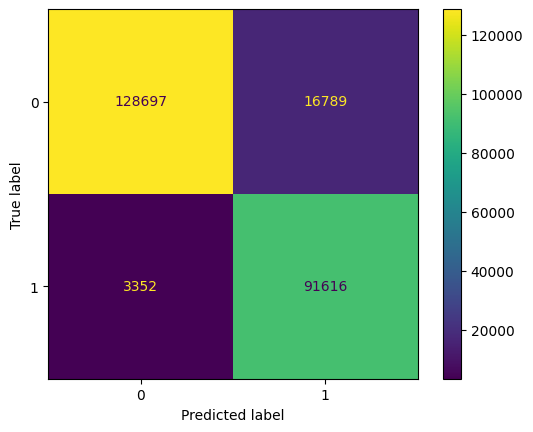

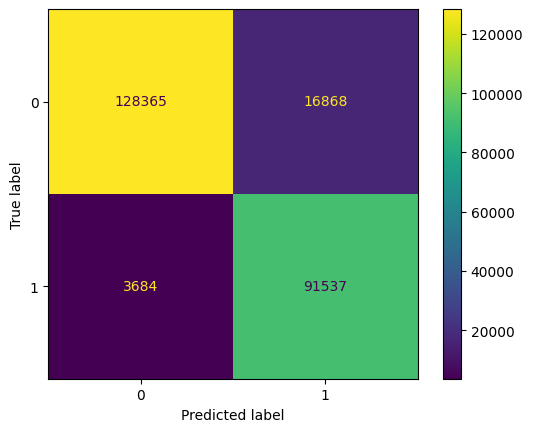

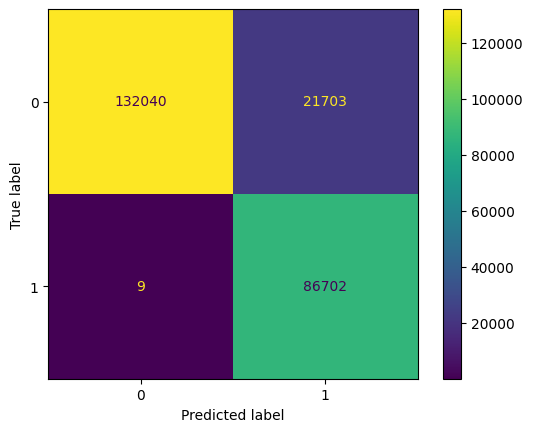

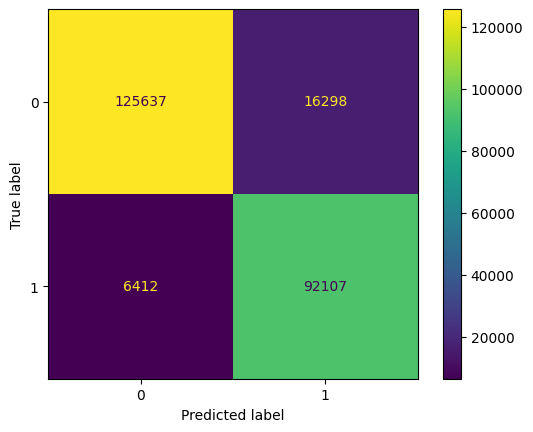

In [33]:
rocdisplay(lr_pred)
rocdisplay(rf_pred)
rocdisplay(dt_pred)
rocdisplay(mlp_pred)

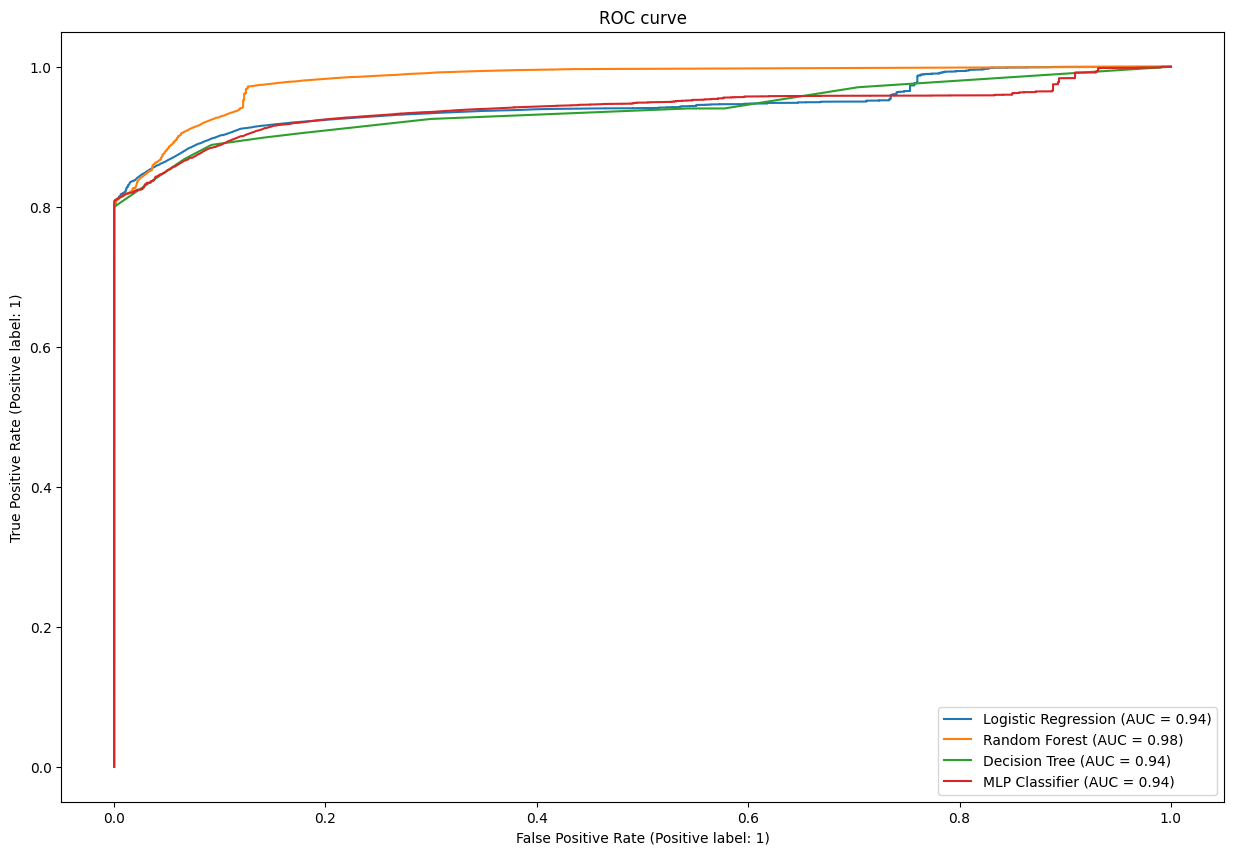

In [34]:
models = [
    ("Logistic Regression", lr),
    ("Random Forest", rf),
    ("Decision Tree", dt),
    ('MLP Classifier', mlp)
]
fig, ax = plt.subplots(figsize=(15,10))
model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, xtest, ytest, ax=ax, name=name)
_ = ax.set_title('ROC curve')

In [35]:
  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            #precision = cf[1,1] / sum(cf[:,1])
            #recall    = cf[1,1] / sum(cf[1,:])
            #f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.2%}".format(accuracy)
        else:
            stats_text = "\n\nAccuracy={:0.2%}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [36]:
def confu(x):
    labels = ['True Neg','False Pos','False Neg','True Pos']
    make_confusion_matrix(confusion_matrix(ytest, x), 
                      group_names=labels,
                      cmap='viridis')

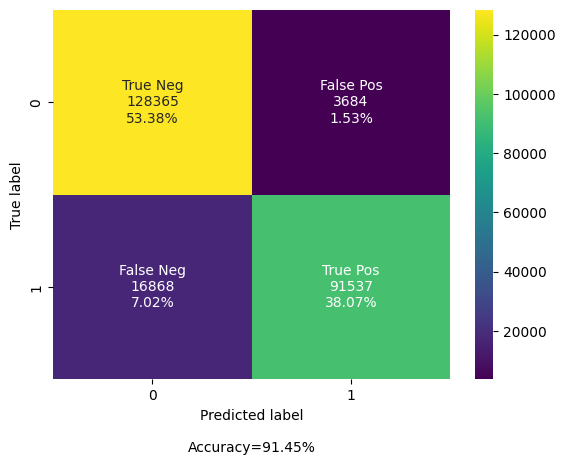

In [37]:
confu(rf_pred)

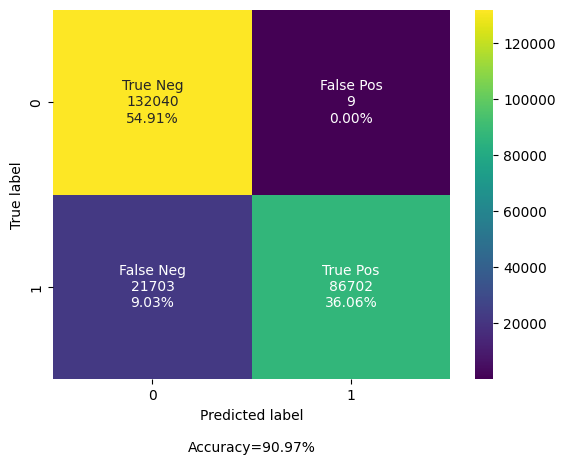

In [38]:
confu(dt_pred)

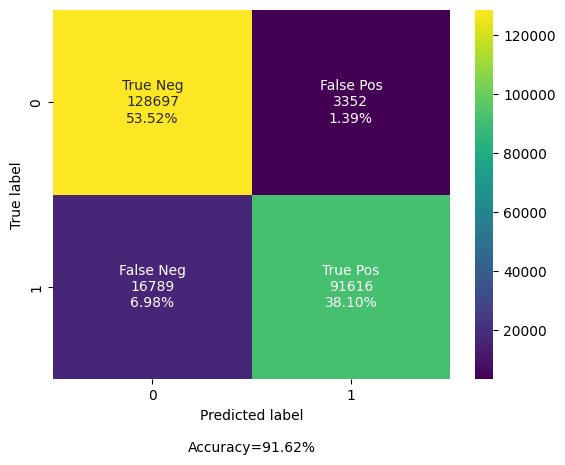

In [39]:
confu(lr_pred)

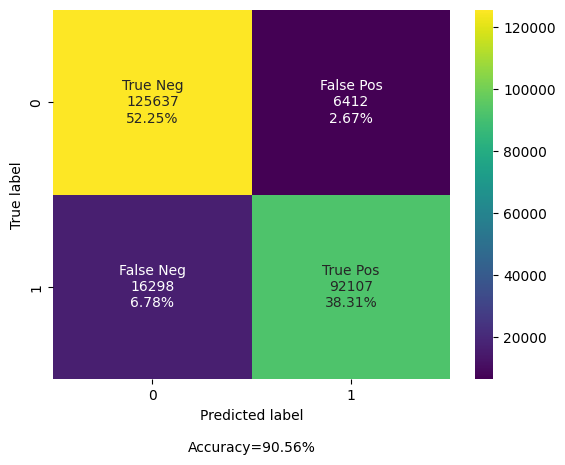

In [40]:
confu(mlp_pred)